# Assignment 3
This assignment consists of 10 exercises divided over two notebooks. Each exercise will come with some tests that are used to verify whether your code is correct. If you pass these tests then you are rewarded *full points*; if your code fails then you will get *no points*. Make sure to **read the rules** before you start the assignment.

## Rules
For this assignment the following rules apply:

**General**
 * The assignment should be completed with the same **groups of three** as the previous assignment
 * Any kind of intergroup discussion will be considered fraud and both the parties will be punished.
 * All code must be written intra group. All external help, with the exception of Python/library documentation and the lecture slides, will be considered fraud.
 * Do not use libraries that implement the assignment for you.

**Grading**
 * If a test cell runs without error (warnings are allowed) then you receive full points.
 * If a test cell throws an error for any reason then you receive 0 points.
  * If a cell takes more than five minutes to complete then this is considered an error.
 * If your code fails a test for *any reason* then you receive 0 points for that exercise.
 * Your grade is computed as $\frac{\text{points}}{\text{max_points}} * 9 + 1$ and will be rounded to the closest 0.5 point.
 * Submit your code to Brightspace as a zip file containing only the notebook (`*.ipynb`) files.
 * **Do not rename the notebook files**
 
**Late Submissions**
 * Late submissions must be submitted *as soon as possible* to the "Assignment 3 - Late Submissions" assignment on Brightspace.
 * The following penalty will be applied: $\text{adjusted grade} = \text{grade} - 1 - \lceil \frac{\text{minutes late}}{10} \rceil$

<br />
 
**Before you submit**, make sure that you are not accidentaly using any global variables. Restart the kernel (wiping all global variables) and run the code from top to bottom by clicking "Kernel" => "Restart & Run all" in the menu bar at the top.

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy
import scipy.linalg
import os
# helpers.py is one level up in the directory structure so we need to tell Python were to find it
import sys
sys.path.append("../../")
import helpers
local_data_folder = os.path.join(helpers.dataset_folder, "week3", "inpainting")

# Pull-Push algorithm

The Pull-Push algorithm is a simple inpainting technique that fills missing part of an image by propagating mean (average) values from neighboring valid regions. The algorithm proceeds in two phases. First, an image pyramid is build by aggregating valid information from the image (pull). Second, the information from the top of the pyramid is propagated down and interpolated into the previously empty bins (push). This results in each image pixel receiving the information from an image area proportional to the size of the hole as larger holes will generally be filled in higher levels of the pull-push pyramid representing mean of a larger portion of the image. While the technique cannot resolve any higher-order statistical properties (gradients, curvatures,...), it provides a visually continuous transition between the original image content and the smooth inpainted regions.

## Exercise 1 (3 points)

First, we will implement a step of the pull phase which generates a new image of half the original size.

Implement a function that aggregates information from an image $\mathbf{I^i} \in \mathcal{R}^{H \times W\times 3}$ into a new image $\mathbf{I^{i+1}} \in \mathcal{R}^{H/2 \times W/2 \times 3}$. Each pixel of $\mathbf{I^{i+1}}$ contains a mean value of valid pixels in a corresponding $2\times2$ region of $\mathbf{I^i}$. A pixel is valid if the weight $M^i \in \{0,1\}^{H \times W\times 3}$ = 1 at a given location. 
You can assume that $W = H$ and $W = 2^{k}$ for $k\in\mathcal{N}$ (that is $\mathbf{I^i}$ is a square image with sides divisible by two).

As a second output return new pixel weights
$$
M^{i+1} \in \{0,1\}^{H/2 \times W/2} =
\begin{cases}
    1,             & \text{if } \text{at least one of the $2\times2$ inputs is valid} \\
    0,             & \text{otherwise.}
\end{cases}
$$

Set $\mathbf{I}^{i+1} = \mathbf{0}$ where $M^{i+1} = 0$.

C:\Users\Bas\Anaconda3\envs\vdp\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Bas\Anaconda3\envs\vdp\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
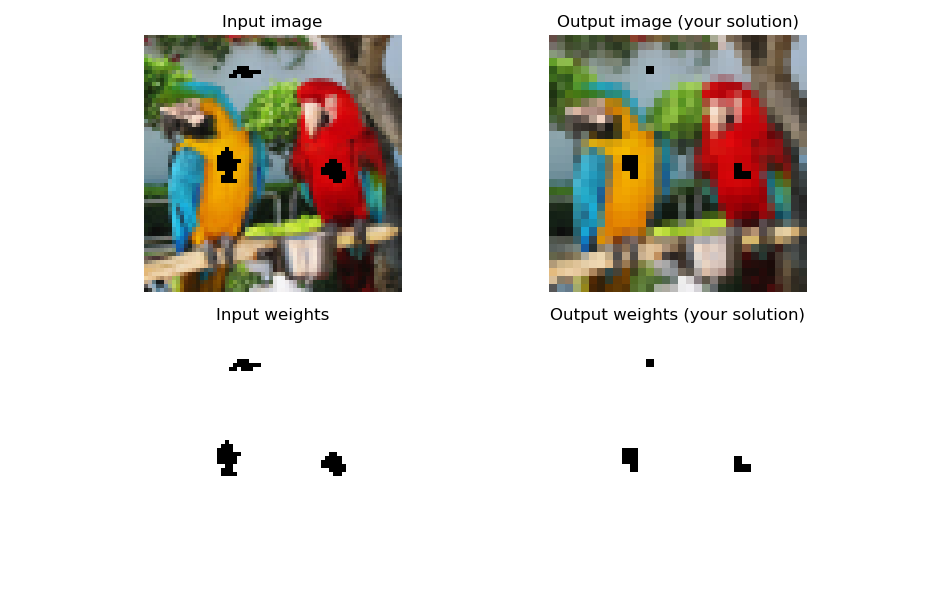

In [2]:
def pull_next_level(image, weights):
    # YOUR CODE HERE
    H, W = image.shape[0], image.shape[1]
    im_next = np.zeros((int(H/2), int(H/2), 3))
    weights_next = np.zeros((int(H/2), int(H/2)))
    
    for i in range(H//2):
        for j in range(H//2):
            area_weights = np.array([weights[i*2,j*2],weights[i*2+1,j*2],weights[i*2,j*2+1],weights[i*2+1,j*2+1]])
        
            if 1.0 in area_weights:
                weights_next[i,j] = 1
            else:
                weights_next[i,j] = 0
            
            area0 = [image[i*2,j*2],image[i*2+1,j*2],image[i*2,j*2+1],image[i*2+1,j*2+1]]
            area = []
            
            for a in range(len(area0)):
                if area_weights[a]>0:
                    area.append(area0[a])
            
            x = np.mean(area, axis=0)
            im_next[i,j] = np.array(x)
            
    return (im_next, weights_next)
    
image = helpers.imread_normalized_float(os.path.join(local_data_folder, "pyramid", "im_02.png"))
weights = helpers.imread_normalized_float_grayscale(os.path.join(local_data_folder, "pyramid", "w_02.png"))
image[weights == 0] = 0

im_next, weights_next = pull_next_level(image, weights)

helpers.show_images({
    "Input image": image, 
    "Output image (your solution)": im_next,
    "Input weights": weights, 
    "Output weights (your solution)": weights_next
}, nrows=2, ncols=2)

### Testing your solution of exercise 1
Verify by hand whether you think your solution to exercise 1 is correct. For example: use your mouse to hover over the input image and write down some pixel values in a small region. Work out the expected output by hand and compare it with what your function produces.

## Excercise 2 (2 points)
Repeat the pull step to build the entire image pyramid. 
Return a tuple with two lists: images and weight maps, both lists should be sorted from the largest (= the input) to the smallest.
Note, that the last level of the pyramid will be a single pixel image $\mathbf{I}^N \in \mathcal{R}^{1 \times 1 \times 3}$ and that $\mathbf{M}^N = 1$. You can again assume that the input is a square image with sides divisible by two.

Your solution:


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
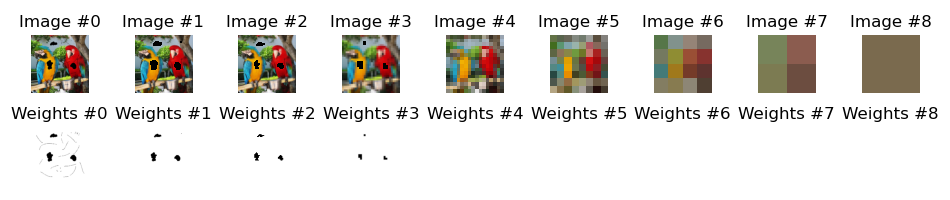

In [3]:
def build_pyramid(image, weights):
    pyramid_im = [image]
    pyramid_w = [weights]
    while len(image) > 1:
        image, weights = pull_next_level(image, weights)
        pyramid_im.append(image)
        pyramid_w.append(weights)
    return (pyramid_im, pyramid_w)

    
image = helpers.imread_normalized_float(os.path.join(local_data_folder, "parrots_256.jpg"))
weights = (helpers.imread_normalized_float_grayscale(os.path.join(local_data_folder, "parrots_mask_256.png")) > 0.5).astype(float)
image[weights == 0] = 0

pyramid_im, pyramid_w = build_pyramid(image, weights)

print("Your solution:")
panels = { f"Image #{i}": im for i, im in enumerate(pyramid_im)}
panels.update({ f"Weights #{i}": im for i, im in enumerate(pyramid_w)})
helpers.show_images(panels, nrows=2, ncols=len(pyramid_im), col_height=1)

### Testing your solution of exercise 2
Verify your solution by hand using the same method as in exercise 1. We provide a couple of basic tests to ensure that you return the values in the correct format for the grading tests.

In [4]:
image = np.ones((128, 128, 3))
weights = np.zeros((128, 128))
weights[62:64, 64:67] = 0
image_pyramid, weights_pyramid = build_pyramid(image, weights)
assert(len(image_pyramid) == 8) # 128, 64, 32, 16, 8, 4, 2, 1
assert(image_pyramid[1].shape == (64, 64, 3))
assert(len(weights_pyramid) == 8) # 128, 64, 32, 16, 8, 4, 2, 1
assert(weights_pyramid[1].shape == (64, 64))


## Exercise 3 (4 points)
The push phase of the algorithm fills the missing pixels $\mathbf{x}$ in the (larger) lower pyramid level $\mathbf{I}^{i}$ by bilinear interpolation of the 4 nearest pixels in (smaller) pyramid level $\mathbf{I}^{i+1}$ above.

The first step is to determine indices of the nearest 

Now we need to find the 4 nearest pixels $A, B, C, D$ which we interpolate to fill the pixel $\mathbf{x}$.

Below you can see how the small pixels in $\mathbf{I^i}$ (thin blue lines) overlap with large pixels $a,b,c,d$ in $\mathbf{I^{i+1}}$ (thick black lines):

<img src="push_grid3.png" alt="Interpolation grid" style="width: 30%;"/>

While pixels are visualized as square patches, for the interpolation it is important to define their exact location. This is typically done by assigning the pixel color to the center of each pixel (see the circles). We can then compute exact position of any point within the pixel grid with subpixel accuracy.

### Example
In the image above, the point $\mathbf{x}^{i} = [2.5, 1.5]$ lies in the center of a pixel $\mathbf{u}^{i} = [2, 1]$ in the high-resolution image $\mathbf{I}^{i}$. The same point projected to the low-resolution image $\mathbf{I}^{i+1}$ will lie in the pixel $\mathbf{u}^{i+1} = [1, 0]$ and have subpixel coordinates $\mathbf{x}^{i+1} = [1.25, 0.75]$.

The point lies within a $2 \times 2$ neighborhood defined by the centers of pixels a, b, c, d. Subtracting the position of $a$'s center we get a normalized position of the point as $\mathbf{x}^{i+1}_{norm} = [0.75, 0.25]$ which can then be used for bilinear interpolation.

### Task
For a given pixel $\mathbf{u}^{i}$ of the low-resolution image $\mathbf{I}^{i}$ (yellow pixel in the Figure) and its center  $\mathbf{x}^{i}$, find the 4 nearest pixels in $\mathbf{I}^{i+1}$ (see $a, b, c, d$ in the Figure). Return the integer index of the left-top pixel (see $a$) and the relative subpixel position $\mathbf{x}^{i+1}_{norm}$ within the 4 neighboring points. 

Note, that knowledge of the image size or content is not required for this exercise.
Assume that the image is infinite, i.e., both positive and negative coordinates are allowed.

In [93]:
def project_point_up(px_coordinate_in_down):
    index_start = [px_coordinate_in_down[0]-2, px_coordinate_in_down[1]-1] #in I^i
    index_start = (px_coordinate_in_down-1)//2
    #a = [(px_coordinate_in_down[0])/2, (px_coordinate_in_down[1])/2] #in I^i+1, center of a
    #subpixel_position = [new_index[0] - a[0], new_index[1] - a[1]]
    new_index = np.array([(i+0.5)/2 for i in px_coordinate_in_down]) #in I^i+1, coordinate of x
    a = np.array([(i+0.5) for i in index_start])
    subpixel_position = new_index-a
    return index_start, subpixel_position #index_strart in I^i

index_start, subpixel_position = project_point_up(np.array([3, 1]))
print("Input point [3, 1]")
print(f'The nearest left-top pixel in the smaller image is {index_start}.')
print(f'The normalized position is {subpixel_position}.')
print(f'The reference solution is [1, 0] and [0.25, 0.25]')

Input point [3, 1]
The nearest left-top pixel in the smaller image is [1 0].
The normalized position is [0.25 0.25].
The reference solution is [1, 0] and [0.25, 0.25]


### Testing your solution of exercise 3
Try to come up with more inputs and work them out by hand. Does your solution produce the correct result for these cases?

## Exercise 4 (2 points)
Next, we need to combine the colors from the 4 nearest pixels using bilinear interpolation.

Given the 4 nearest pixel color values $\{\mathbf{I}^{i}(\mathbf{a}), \mathbf{I}^{i}(\mathbf{b}), \mathbf{I}^{i}(\mathbf{c}), \mathbf{I}^{i}(\mathbf{d})\} \in \mathcal{R}^{4\times3}$ and a normalized point position $\mathbf{x} = (\alpha, \beta) \in [0,1]\times[0,1]$, compute interpolated value using bilinear interpolation.

<img src="bilinterp.png" alt="Interpolation grid" style="width: 30%;"/>

Bilinear interpolation is a weighted mean of 4 corner values with weights proportional to areas of rectangle adjacent to each of the source vertices. It can also be separated into 3 one-dimensional linear interpolations by first interpolating the the between $a$ and $b$, and $d$ and $c$ using $\alpha$ and then interpolating the intermediate results in an orthogoval dimension defined by $\beta$.

In [88]:
def bilinear_interpolation(col_a, col_b, col_c, col_d, x):
    alpha, beta = x
    fX0 = col_a*(1-alpha)+col_b*alpha
    fX1 = col_d*(1-alpha)+col_c*alpha
    res = fX0*(1-beta)+fX1*beta
    return res
    
    
a = np.array([1.0, 0, 0])
b = np.array([0, 1.0, 0])
c = np.array([0, 0, 1.0])
d = np.array([1.0, 1.0, 1.0])
x = np.array([0.75, 0.25])

interpolated = bilinear_interpolation(a,b,c,d,x)

print(f'The interpolated color at {x} was computed as {np.array2string(interpolated, precision=3)}')

The interpolated color at [0.75 0.25] was computed as [0.25  0.625 0.25 ]


### Testing your solution of exercise 4
Try to come up with more inputs and work them out by hand. Does your solution produce the correct result for these cases?

## Exercise 5 (4 points)

Now we can combine Excercise 3 and 4 together and implement an entire push phase. 

Implement a method that collapses the image pyramid $\mathbf{I}^{0..N}$ in the up-down direction and fills missing pixels in each larger high-resolution image $\mathbf{I}^{i}$ by interpolating a corresponding low-resolution image $\mathbf{I}^{i+1}$.
Do not modify pixels that are marked as valid in the provided weights map $M^{i}$.

### Notes
Visit every level of the pyramid from the top to the bottom.
Test every output pixel and update values of those pixels that are not yet valid. 
For each such pixel find the 4 neighboring low-resolution pixels and relative pixel position using the code from Exercise 3.
Use the relative position as bilinear interpolation weights.
Take a special care for pixels that lie close to the image boundary as one of the four neighbors can lie outside of $\mathbf{I}^{i+1}$. Clamp the coordinates of such neighbor pixel to the domain on $\mathbf{I}^{i+1}$.

Your solution:


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
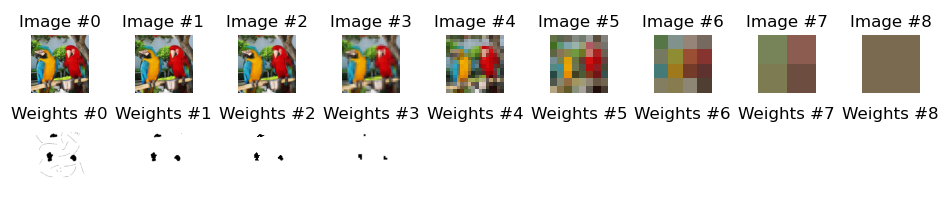

In [101]:
def push_pyramid(im_pyramid, w_pyramid):
    # Interpolate im_pyramid[i+1] to fill im_pyramid[i] where w_down == 0.
    index = len(im_pyramid)-1
    for num in range(index, -1, -1):
        for row in range(w_pyramid[num].shape[0]):
            for col in range(w_pyramid[num].shape[1]):
                if w_pyramid[num][row][col] < 1:                
                    index_start, subpixel_position = project_point_up(np.array([row, col]))
                    a = im_pyramid[num+1][int(index_start[0])][int(index_start[1])]
                    b = im_pyramid[num+1][int((index_start[0]+1))][int(index_start[1])]
                    d = im_pyramid[num+1][int(index_start[0])][int((index_start[1]+1))]
                    c = im_pyramid[num+1][int((index_start[0]+1))][int((index_start[1]+1))]
                    color = bilinear_interpolation(a, b, c, d, subpixel_position)
                    im_pyramid[num][row][col] = color
    # Modify im_pyramid in-place (do not edit a copy).
    
    # YOUR CODE HERE
    
im_files = sorted(helpers.list_files_in_folder(os.path.join(local_data_folder, 'pyramid'), filter="im_*.png"))
im_pyramid = [helpers.imread_normalized_float(f) for f in im_files]
w_files = sorted(helpers.list_files_in_folder(os.path.join(local_data_folder, 'pyramid'), filter="w_*.png"))
w_pyramid = [helpers.imread_normalized_float_grayscale(f) for f in w_files]

push_pyramid(im_pyramid, w_pyramid)

print("Your solution:")
panels = { f"Image #{i}": im for i, im in enumerate(im_pyramid)}
panels.update({ f"Weights #{i}": im for i, im in enumerate(w_pyramid)})
helpers.show_images(panels, nrows=2, ncols=len(pyramid_im), col_height=1)

### Testing your solution of exercise 5
The image pyramid should now not contain any holes anymore. Verify that the interpolated values are correct by creating a simple base case (e.g. 4x4 image that you create yourself) and verifying that bilinear interpolation is working correctly.

## Exercise 6 (3 points)
Now we have all the necessary components of a complete Pull-Push algorithm and we can use it for image inpainting.
In this exercise we will remove red text caption that has been embedded into a photograph.

Implement a method that accepts an image (squre shape, side is power of 2), removes any red text and inpaints the resulting holes using the Pull-Push algorithm.

### Notes
The red text is guaranteed to have a fully saturated red color (RGB value $[1, 0, 0]$). You should remove any such pixels anywhere in the image.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
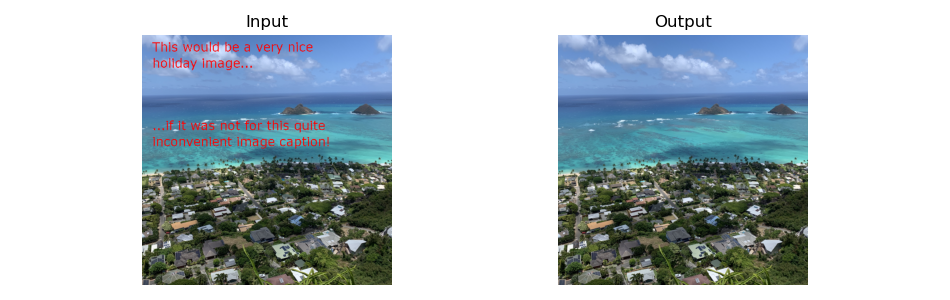

In [103]:
def remove_red_text(image):
    rows, cols, RGB = image.shape
    weights = np.ones((rows, cols))
    for row in range(rows):
        for col in range(cols):
            if image[row,col][0] >= 1 and image[row,col][1] <= 0.0 and image[row,col][2] <= 0.0:
                weights[row,col] = 0
    pyramid_im, pyramid_w = build_pyramid(image, weights)
    clean_image = push_pyramid(pyramid_im, pyramid_w)
    clean_image = pyramid_im[0]
    return clean_image

image = helpers.imread_normalized_float(os.path.join(local_data_folder, "image_with_text.png"))
clean_image = remove_red_text(image.copy())

panels = { f"Output #{i}": im for i, im in enumerate(pyramid_im)}
helpers.show_images({
    'Input': image,
    'Output': clean_image
}, nrows=1, ncols=2)

### Testing your solution of exercise 6
Your solution should have gotten rid of the red text in the image. You can try to create a couple of different images and check whether your method still works.